# RandomForestClassifier

Este modelo se trata de un ensamble de muchos árboles de decisión, con el fin de reducir la varianza del modelo resultante. Como ya entrenamos un árbol de decisión simple, podemos usar los hiperparámetros conseguidos en dicho modelo como estimador base para el random forest.

In [1]:
%load_ext autoreload
%autoreload 2
from preprocessing import *
from scoring import *
from sklearn.metrics import roc_auc_score, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import CalibratedClassifierCV
from sklearn.pipeline import Pipeline
import pandas as pd
import numpy as np
pd.set_option('display.max_rows', 10)

## Preprocessing Nº1

In [2]:
df_features, df_target = get_datasets(fecha_to_int=False)

common(df_features, df_target, fecha_to_int=False)
viento_trigonometrico(df_features)
df_features = dia_a_mes(df_features)

# Dropeamos la feature de barrio porque vimos que en los arboles de decision
# no fue una feature util
df_features = drop_categoricas(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.2, random_state=0)

pipe = simple_imputer()
pipe.fit(X_train)

X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

## Grid search de hiperparámetros

In [3]:
parameters = {
    "n_estimators": np.arange(100,500,50),
}

grid = GridSearchCV(RandomForestClassifier(criterion="entropy", max_depth=9, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.872951887466534

In [4]:
grid_history_table(grid)

,param_n_estimators,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,300,0.872952,0.846354,0.781768,0.435297,0.559207
1,350,0.872925,0.846232,0.780854,0.435461,0.559105
2,250,0.872914,0.846452,0.781403,0.436279,0.559921
3,450,0.872898,0.846476,0.782083,0.435734,0.559647
4,400,0.872884,0.846183,0.781092,0.434915,0.558715
5,200,0.872812,0.845841,0.779498,0.434370,0.557854
6,150,0.872805,0.846305,0.781175,0.435570,0.559278
7,100,0.872559,0.845841,0.778954,0.434915,0.558156


In [5]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.87517,0.849033,0.793009,0.440637,0.566498


Los modelos resultaron ser un poco mejores que al utilizar un único árbol (~$87.5\%$ vs ~$87\%$ en AUC ROC). Es interesante notar que los modelos con pocos estimadores también dieron buenos resultados. Sin embargo, no es un hiperparámetro que suela generar overfit, por lo que podemos decir que el mejor modelo resultante de este entrenamiento es el primero.

De todas formas, el aumento en score no parece ser tan significativo como para considerarlo mejor que un árbol de decisión, ya que el incremento en complejidad es bastante alto, lo que conlleva a una disminución de la interpretabilidad.

### Matriz de confusión

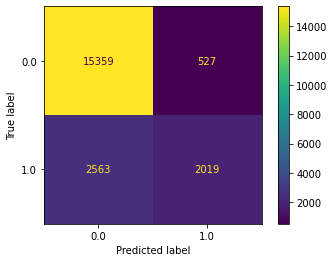

In [6]:
ConfusionMatrixDisplay.from_predictions(Y_test, grid.best_estimator_.predict(X_test))

Tal y como vimos con los árboles de decisión, hay una gran cantidad de falsos negativos. Podemos intentar mejorar esto balanceando los pesos de las clases.clases

## Balanceo de pesos

In [7]:
# Reducimos la busqueda de hiperparametros
# utilizando lo aprendido en el modelo anterior
parameters = {
    "n_estimators": np.arange(100,500,100),
}

grid = GridSearchCV(RandomForestClassifier(criterion="entropy", max_depth=9, class_weight="balanced", random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8730179502119106

In [8]:
grid_history_table(grid)

,param_n_estimators,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,400,0.873018,0.802626,0.542518,0.756137,0.631750
1,300,0.873018,0.802846,0.542883,0.756519,0.632131
2,200,0.872927,0.802993,0.543126,0.757065,0.632484
3,100,0.872545,0.802296,0.541939,0.756901,0.631616


In [9]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.875395,0.805257,0.546811,0.759712,0.635915


La variación en los resultados es similar a lo que ocurrio en el árbol de decisión (aumento de Recall y disminución de Precision). La métrica que se busca optimizar no mejoró.

### Importancia de las features

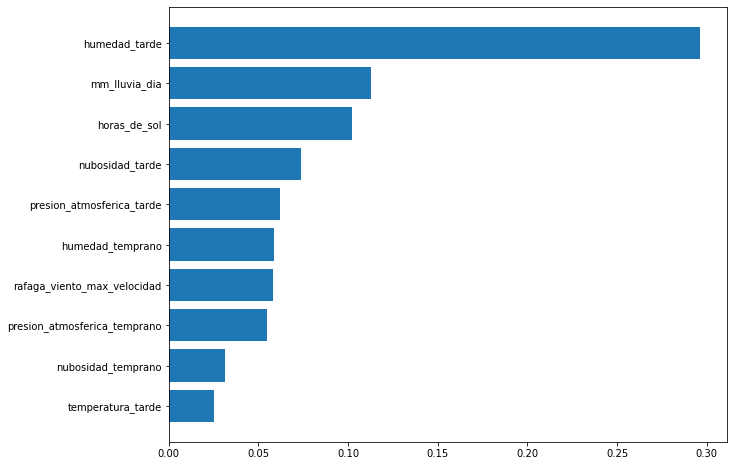

In [10]:
plot_feature_importances(df_features.columns, grid.best_estimator_.feature_importances_, size=10, head=True)

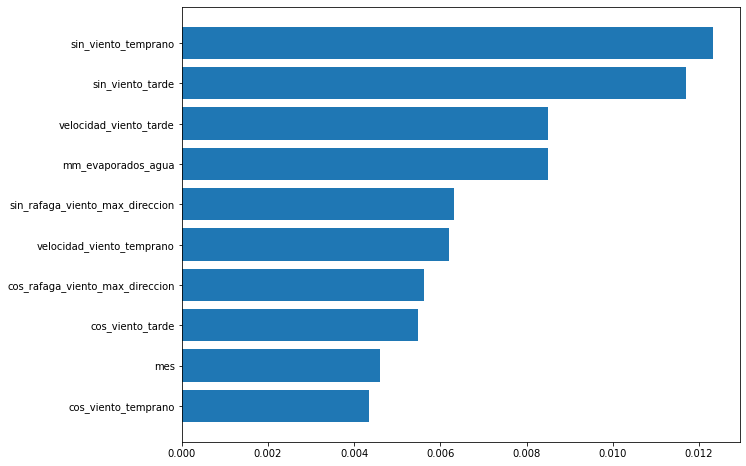

In [11]:
plot_feature_importances(df_features.columns, grid.best_estimator_.feature_importances_, size=10, head=False)

A diferencia de los árboles de decisión, en el random forest las importancias de las features se encuentran distribuidas de una forma más equitativa. Esto es porque cada árbol recibe un subset de features que puede utilizar para las predicciones, por lo que no siempre podrá utilizar los mejores predictores del dataset.

## Preprocessing Nº2

In [12]:
df_features, df_target = get_datasets(fecha_to_int=False)

common(df_features, df_target, fecha_to_int=False)
viento_trigonometrico(df_features)
df_features = dia_a_mes(df_features)

df_features = drop_categoricas(df_features)

X_train, X_test, Y_train, Y_test = train_test_split(df_features, df_target, stratify=df_target.values, test_size=0.2, random_state=0)

pipe = standarizer()
pipe = iterative_imputer(max_iter=100)

pipe.fit(X_train)
X_train = pipe.transform(X_train)
X_test = pipe.transform(X_test)

Y_train = np.ravel(Y_train)
Y_test = np.ravel(Y_test)

In [13]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(5, 70, 10),
}

grid = GridSearchCV(RandomForestClassifier(n_estimators=200, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8856277413989426

In [14]:
grid_history_table(grid)

,param_criterion,param_max_depth,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,entropy,35,0.885628,0.854819,0.764309,0.508347,0.610570
1,entropy,45,0.885605,0.854306,0.762155,0.507747,0.609449
2,entropy,55,0.885605,0.854306,0.762155,0.507747,0.609449
3,entropy,65,0.885605,0.854306,0.762155,0.507747,0.609449
4,entropy,25,0.885432,0.854684,0.763025,0.509056,0.610685
...,...,...,...,...,...,...,...
9,gini,55,0.882868,0.854171,0.760232,0.509329,0.609967
10,gini,65,0.882868,0.854171,0.760232,0.509329,0.609967
11,gini,15,0.881531,0.853194,0.761093,0.501855,0.604851
12,entropy,5,0.858720,0.838952,0.783477,0.387943,0.518914


In [15]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.887824,0.859146,0.783829,0.512003,0.619406


El score aumentó bastante (más de $1\%$), por lo que el preprocessing Nº2 fue más útil que el Nº1

### Utilizando bootstrap

Podemos indicarle al random forest que tome una fracción de las instancias para entrenar a cada modelo, con el fin de disminuir aun más la dependencia entre árboles

In [16]:
parameters = {
    "criterion": [
        "gini",
        "entropy"
    ],
    "max_depth": np.arange(5, 70, 10),
}

grid = GridSearchCV(RandomForestClassifier(n_estimators=200, bootstrap=True, oob_score=True, random_state=0),
                    param_grid=parameters,
                    cv = StratifiedKFold(5),
                    refit = METRIC,
                    scoring = SCORINGS,
                    n_jobs = -1)

grid.fit(X_train, Y_train)
grid.best_score_

0.8856277413989426

In [17]:
grid_history_table(grid)

,param_criterion,param_max_depth,mean_test_roc_auc,mean_test_accuracy,mean_test_precision,mean_test_recall,mean_test_f1
0,entropy,35,0.885628,0.854819,0.764309,0.508347,0.610570
1,entropy,45,0.885605,0.854306,0.762155,0.507747,0.609449
2,entropy,55,0.885605,0.854306,0.762155,0.507747,0.609449
3,entropy,65,0.885605,0.854306,0.762155,0.507747,0.609449
4,entropy,25,0.885432,0.854684,0.763025,0.509056,0.610685
...,...,...,...,...,...,...,...
9,gini,55,0.882868,0.854171,0.760232,0.509329,0.609967
10,gini,65,0.882868,0.854171,0.760232,0.509329,0.609967
11,gini,15,0.881531,0.853194,0.761093,0.501855,0.604851
12,entropy,5,0.858720,0.838952,0.783477,0.387943,0.518914


In [18]:
metrics_table(Y_test, grid.best_estimator_.predict(X_test), grid.best_estimator_.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.887824,0.859146,0.783829,0.512003,0.619406


No se observa ninguna mejora en los scores

### Calibrando el modelo

Intentamos mejorar el mejor modelo obtenido hasta ahora realizando una calibración del mismo

In [19]:
rf = RandomForestClassifier(criterion="entropy",
                            n_estimators=300,
                            max_depth=35,
                            n_jobs=-1,
                            random_state=0)

calib = CalibratedClassifierCV(rf)
calib.fit(X_train, Y_train)

CalibratedClassifierCV(base_estimator=RandomForestClassifier(criterion='entropy',
                                                             max_depth=35,
                                                             n_estimators=300,
                                                             n_jobs=-1,
                                                             random_state=0))

In [20]:
metrics_table(Y_test, calib.predict(X_test), calib.predict_proba(X_test)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.888955,0.85939,0.764104,0.537975,0.631404


Los resultados mejoraron muy ligeramente, lo cual puede deberse a la calibración, o a una casualidad azaroza.

## Modelo final

El último modelo obtuvo el mejor score (aunque no varió mucho respecto de otros resultados), y como todos los entrenamientos resultaron en modelos con complejidades similares, podemos tomarlo como el mejor modelo

## Predicción de nuevos datos

In [21]:
df_extra = pd.read_csv("datasets/df_extra.csv", low_memory = False, index_col = "id")

common(df_extra, fecha_to_int=False)
viento_trigonometrico(df_extra)
df_features = dia_a_mes(df_extra)
df_features = drop_categoricas(df_extra)

model = grid.best_estimator_

pipe.steps.append(("random_forest", model))

df_extra_predict = pd.DataFrame({"id": df_extra.index, "llovieron_hamburguesas_al_dia_siguiente": pipe.predict(df_extra)})
df_extra_predict.set_index("id", inplace = True)
df_extra_predict.replace({"llovieron_hamburguesas_al_dia_siguiente": {0.0: "no", 1.0: "si"}}, inplace = True)
df_extra_predict.to_csv("predicciones/RandomForestClassifier.csv")

## Predicción en Holdout

In [22]:
df_features_holdout = pd.read_csv("datasets/df_features_holdout.csv", low_memory = False, index_col = "id")
df_target_holdout = pd.read_csv("datasets/df_target_holdout.csv", low_memory = False, index_col = "id")

common(df_features_holdout, df_target_holdout, fecha_to_int=False)
viento_trigonometrico(df_features_holdout)
df_features_holdout = dia_a_mes(df_features_holdout)
df_features_holdout = drop_categoricas(df_features_holdout)

In [23]:
metrics_table(df_target_holdout, pipe.predict(df_features_holdout), pipe.predict_proba(df_features_holdout)[:,1])

,AUC-ROC,Accuracy,Precision,Recall,F1 Score
0,0.887376,0.853856,0.766687,0.493886,0.600768


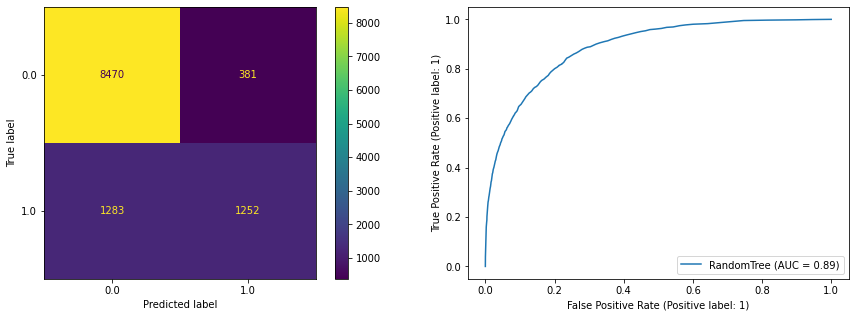

In [24]:
fig, axs = plt.subplots(1, 2, figsize=(15,5))

ConfusionMatrixDisplay.from_predictions(df_target_holdout, pipe.predict(df_features_holdout), ax=axs[0])
RocCurveDisplay.from_predictions(df_target_holdout, pipe.predict_proba(df_features_holdout)[:,1], ax=axs[1], name="RandomTree")
plt.show()

Vemos que las predicciones fueron bastante buenas. Los scores diminuyeron un poco (excepto Precision, que aumentó un $0.26\%$), como es esperable, pero el área bajo la curva ROC se mantuvo prácticamente igual. Las métricas que más empeoraron fueron Recall y F1 Score. Esto indica que se detectó un porcentaje menor de instancias positivas, con lo cual el número de *True Positives* fue menor.